# Patch Attack Details on Object Detection 
This notebook provides a beginner friendly introduction to using adversarial patches on object detection as part of Test & Evaluation of a the VisDrone dataset. We first run the attack with the default parameters, and then go through the parameters to understand their effect on the resulting patch. In each case, we visualize the resulting patch and the detector's output using the adversarial patch. We then visualize the attack and afterwards constrain the change applied to the image to a fraction of the input image using a patch attack. Computing the performance under such patch attacks is a crucial step in T&E. 

❗**Patches can be effective simply by covering the target object. This has to be taken into account when evaluating**❗

__Intended Audience__: All T&E users 

__Requirements__: Basic Python and Torchvision / ML skills, object detection 

__Time Required__: Full run of the notebook: <4 minutes

__Order of completetion__: 1-3, then arbitrary 

### Contents
1. Imports and set-up
2. Load data and model
3. Initialize patch attack
4. Patch shape
5. Patch position
6. Patch Type
7. Conclusion and 8. Next steps

### Take-aways 
- how to apply a patch attack using JATIC
- which parameters a patch attack uses
- how changing these parameters affects the resulting patch


## 1. Imports and set-up

We import all necessary libraries for this tutorial. In this order, we first import general libraries such as numpy, then load relevant methods from ART. We then load the corresponding HEART functionality and specific torch functions to support the model. Lastly, we use a command to plot within the notebook.

In [1]:
# general imports
import numpy as np
from functools import partial
from pprint import pprint
import cv2
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Any
from copy import deepcopy

# imports from ART
from art.attacks.evasion import AdversarialPatchPyTorch

# imports from HEART
from heart_library.estimators.object_detection import JaticPyTorchObjectDetector
from heart_library.attacks.attack import JaticAttack
from heart_library.metrics import AccuracyPerturbationMetric
from heart_library.metrics import HeartMAPMetric, HeartAccuracyMetric

# dataset imports
from datasets import load_dataset
from datasets import Dataset

# torch imports
import torch
from torchvision.transforms import transforms

# MAITE imports
from maite.protocols.object_detection import TargetBatchType
from maite.workflows import evaluate
from maite.protocols.object_detection import Dataset as od_dataset
from maite.protocols.image_classification import Augmentation
from maite.utils.validation import check_type

plt.style.use('ggplot')
%matplotlib inline

Before loading data and model, we define a couple of methods that we will use later on on the drone data. These encompass getting predictions with a confidence threshold, plotting input images with the predicted bounding boxes, and a special wrapper for image data.

In [2]:
# given a confidence threshold, determine which of the mdoel's predictions are relevent
def extract_predictions(predictions_, conf_thresh):
    # Get the predicted class
    predictions_class = [visdrone_labels[i] for i in list(predictions_.labels)]
    #  print("\npredicted classes:", predictions_class)
    if len(predictions_class) < 1:
        return [], [], []
    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_.boxes)]

    # Get the predicted prediction score
    predictions_score = list(predictions_.scores)
    # print("predicted score:", predictions_score)

    # Get a list of index with score greater than threshold
    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t  # [-1] #indices where score over threshold
    else:
        # no predictions esxceeding threshold
        return [], [], []
    # predictions in score order
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores

#plot an image with objects with the predicted bounding boxes on top
def plot_image_with_boxes(img, boxes, pred_cls, title):
    img = (img*255).astype(np.uint8)
    text_size = 1.5
    text_th = 2
    rect_th = 2

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img, interpolation="nearest")
    # plt.show()
    
#wrapper for image datasets 
class ImageDataset:
    
    metadata = {"id": "example"}
    
    def __init__(self, images, groundtruth, threshold=0.8):
        self.images = images
        self.groundtruth = groundtruth
        self.threshold = threshold
        
    def __len__(self)->int:
        return len(self.images)
    
    def __getitem__(self, ind: int) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
        image = np.asarray(self.images[ind]["image"]).astype(np.float32)
        
        filtered_detection = self.groundtruth[ind]
        filtered_detection.boxes = filtered_detection.boxes[filtered_detection.scores>self.threshold]
        filtered_detection.labels = filtered_detection.labels[filtered_detection.scores>self.threshold]
        filtered_detection.scores = filtered_detection.scores[filtered_detection.scores>self.threshold]
        
        return (image, filtered_detection, None)

# specific dataset class to craft a targeted adversarial patch 
class TargetedImageDataset:
    
    metadata = {"id": "example"}
    
    def __init__(self, images, groundtruth, target_label, threshold=0.5):
        self.images = images
        self.groundtruth = groundtruth
        self.target_label = target_label
        self.threshold = threshold
        
    def __len__(self)->int:
        return len(self.data)
    
    def __getitem__(self, ind: int) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
        image = self.images.__getitem__(ind)["image"]
        targeted_detection = self.groundtruth[ind]
        targeted_detection.boxes = targeted_detection.boxes[targeted_detection.scores>self.threshold]
        targeted_detection.scores = np.asarray([1.0]*len(targeted_detection.boxes))
        targeted_detection.labels = [self.target_label]*len(targeted_detection.boxes)
        return (image, targeted_detection, {})

## 2. Load data and model
We load the data, importing only a small part (5 samples) to save compute for this small demonstration. We then define the model and wrap it as JATIC pytorch classifier and test it's output on our samples.

In [3]:
visdrone_labels = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

NUM_SAMPLES = 5

data = load_dataset("Voxel51/VisDrone2019-DET", split="train", streaming=True)
sample_data = data.take(NUM_SAMPLES)

def gen_from_iterable_dataset(iterable_ds):
    yield from iterable_ds

sample_data = Dataset.from_generator(partial(gen_from_iterable_dataset, sample_data), features=sample_data.features)

IMAGE_H, IMAGE_W = 800, 800

preprocess = transforms.Compose([
    transforms.Resize((IMAGE_H, IMAGE_W)),
    transforms.ToTensor()
])

sample_data = sample_data.map(lambda x: {"image": preprocess(x["image"]), "label": None})

Resolving data files:   0%|          | 0/8632 [00:00<?, ?it/s]

Using cache found in /Users/kgr/.cache/torch/hub/facebookresearch_detr_main


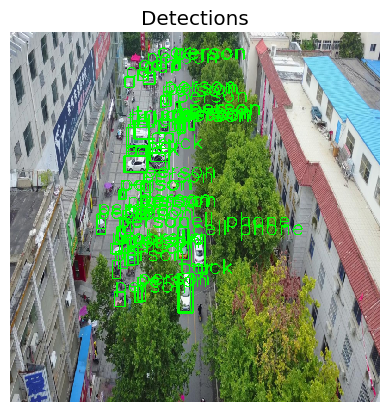

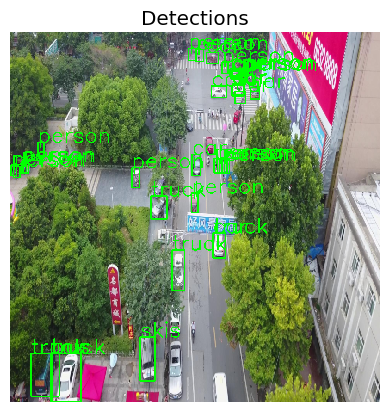

In [4]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225] 
preprocessing=(MEAN, STD)

detector = JaticPyTorchObjectDetector(model_type="detr_resnet50",
                                      device_type='cpu',
                                    input_shape=(3, 800, 800),
                                    clip_values=(0, 1), 
                                    attack_losses=("loss_ce",), 
                                    preprocessing=(MEAN, STD))

detections = detector(sample_data)

# plot the input images with the corresponding classification output
for i in range(2): # to plot all: range(len(sample_data))):
    preds_orig = extract_predictions(detections[i], 0.5)
    img = np.asarray(sample_data.__getitem__(i)['image']).transpose(1,2,0)
    plot_image_with_boxes(img=img.copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

## 3. Initialize patch attack

We will now initialize the patch attack and apply it before investigating individual parameters.


Adversarial Patch PyTorch:   0%|          | 0/50 [00:00<?, ?it/s]

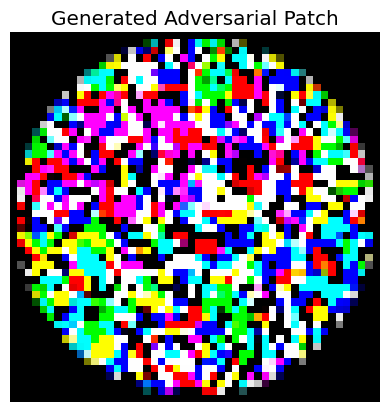

-------------


In [5]:
##### prepare dataset
targeted_data = TargetedImageDataset(sample_data, deepcopy(detections), NUM_SAMPLES)

assert isinstance(targeted_data, od_dataset)

targeted_data = torch.utils.data.Subset(targeted_data, list(range(1)))

##### initialize patch attack parameters
rotation_max=0.0
scale_min=0.5
scale_max=1.0
distortion_scale_max=0.0
learning_rate=0.9
max_iter=50
batch_size=16
patch_shape=(3, 50, 50)
patch_location=(20,20)
patch_type="circle"
optimizer="Adam"

patchAttack = JaticAttack(
    AdversarialPatchPyTorch(detector, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max, optimizer=optimizer, distortion_scale_max=distortion_scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size, patch_location=patch_location,
                      patch_shape=patch_shape, patch_type=patch_type, verbose=True, targeted=True)
    )

#Generate adversarial images
px_adv, y, metadata = patchAttack(data=targeted_data)

patch = metadata[0]["patch"]
patch_mask = metadata[0]["mask"]

#plot patch
plt.axis("off")
plt.imshow(((patch) * patch_mask).transpose(1,2,0))
_ = plt.title('Generated Adversarial Patch')
plt.show()
print('-------------')

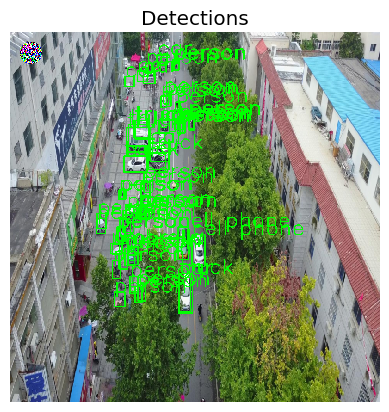

In [6]:
adv_detections = detector(px_adv)
for i in range(1): #to see all, use range(len(adv_detections)): 
    preds_orig = extract_predictions(adv_detections[i], 0.5)
    plot_image_with_boxes(img=px_adv[i].transpose(1,2,0).copy(),
                          boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

We see a small patch in the upper, left corner of the image and some differences in bounding boxes comapred to previously.

### 4. Patch shape

To understand the different parameters, we will now investigate each of them. **Rotation**, **scale**, and **distortion** determine how much the patch is reshaped during training. This can be considered data augmentation that avoids overfitting the patch. Furthermore, the **learning rate**, **max_iter**, **batch-size** and **optimzier** influence the optimization procedure. We will thus in the following investigate the remaining parameters, starting with the patch shape. This parameter denote the size of the patch used for crafting. We increase the size, but decide to only use two instead of three color channels.

**Todo**> Feel free to explore the parameters by yourself and to observe the change in patch position and shape before proceeding.

Adversarial Patch PyTorch:   0%|          | 0/50 [00:00<?, ?it/s]

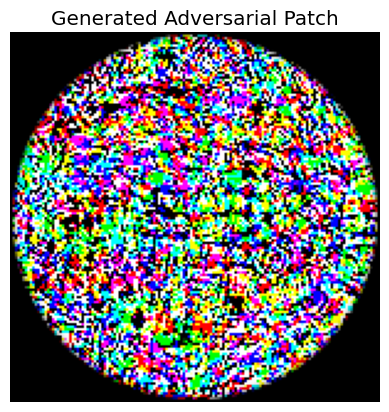

-------------


In [7]:
##### initialize patch attack parameters
patch_shape=(3, 150, 150)
patch_location=(20,20)
patch_type="circle"

patchAttack = JaticAttack(
    AdversarialPatchPyTorch(detector, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max, optimizer=optimizer, distortion_scale_max=distortion_scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size, patch_location=patch_location,
                      patch_shape=patch_shape, patch_type=patch_type, verbose=True, targeted=True)
    )

#Generate adversarial images
px_adv, y, metadata = patchAttack(data=targeted_data)

patch = metadata[0]["patch"]
patch_mask = metadata[0]["mask"]

#plot patch
plt.axis("off")
plt.imshow(((patch) * patch_mask).transpose(1,2,0))
_ = plt.title('Generated Adversarial Patch')
plt.show()
print('-------------')

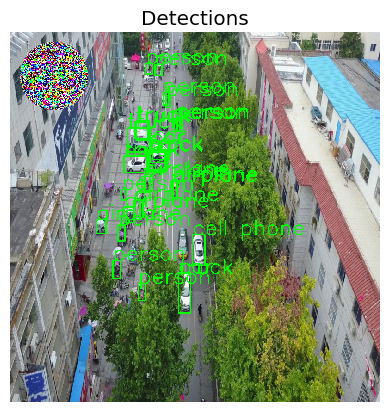

In [8]:
adv_detections = detector(px_adv)
for i in range(1): #to see all, use range(len(adv_detections)): 
    preds_orig = extract_predictions(adv_detections[i], 0.5)
    plot_image_with_boxes(img=px_adv[i].transpose(1,2,0).copy(),
                          boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

As visible, the patch is now much larger, as expected when increasing the patch size. Next, we are going to alter the position of the patch.

## 5. Patch position

The position denotes the offset from the upper left corner, where the patch currently appears. The image is 800 x 800, so we will shift the patch to the middle of the image, keeping the larger size set previously.

Adversarial Patch PyTorch:   0%|          | 0/50 [00:00<?, ?it/s]

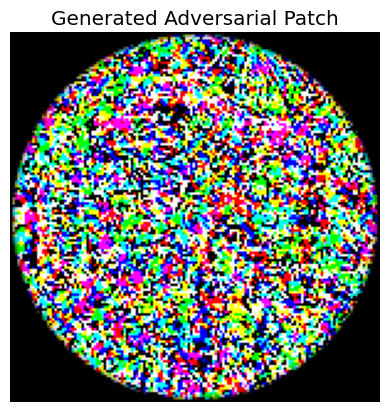

-------------


In [9]:
##### initialize patch attack parameters
patch_shape=(3, 150, 150)
patch_location=(300,300)
patch_type="circle"

patchAttack = JaticAttack(
    AdversarialPatchPyTorch(detector, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max, optimizer=optimizer, distortion_scale_max=distortion_scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size, patch_location=patch_location,
                      patch_shape=patch_shape, patch_type=patch_type, verbose=True, targeted=True)
    )

#Generate adversarial images
px_adv, y, metadata = patchAttack(data=targeted_data)

patch = metadata[0]["patch"]
patch_mask = metadata[0]["mask"]

#plot patch
plt.axis("off")
plt.imshow(((patch) * patch_mask).transpose(1,2,0))
_ = plt.title('Generated Adversarial Patch')
plt.show()
print('-------------')

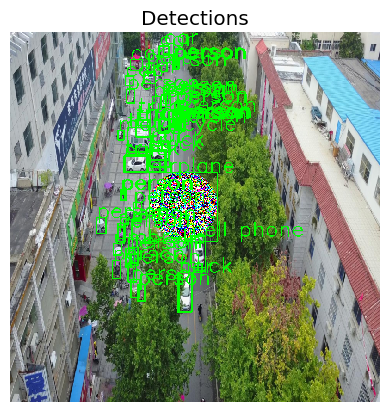

In [10]:
adv_detections = detector(px_adv)
for i in range(1): #to see all, use range(len(adv_detections)): 
    preds_orig = extract_predictions(adv_detections[i], 0.5)
    plot_image_with_boxes(img=px_adv[i].transpose(1,2,0).copy(),
                          boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

We see that as expected, the patch is now further in the middle of the image. 

❗**When evaluating this patch, we have to take into account that it covers some of the objects - e.g., these will dissapear from the evaluation regardless whether the patch is effective or not** ❗

## 6. Patch Type
So far, we have only conisdered round patches. In theory, a patch can have any form, but ART support primarily round and squared patches. To conclude this notebook, we thus change the patch size to square.

Adversarial Patch PyTorch:   0%|          | 0/50 [00:00<?, ?it/s]

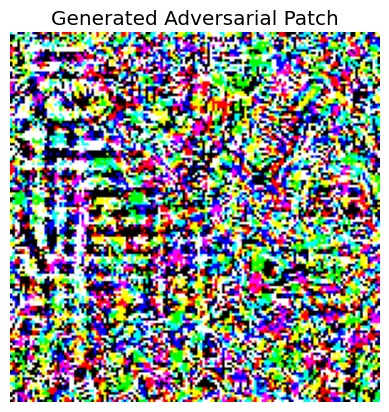

-------------


In [11]:
##### initialize patch attack parameters
patch_shape=(3, 150, 150)
patch_location=(300,300)
patch_type="square"

patchAttack = JaticAttack(
    AdversarialPatchPyTorch(detector, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max, optimizer=optimizer, distortion_scale_max=distortion_scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size, patch_location=patch_location,
                      patch_shape=patch_shape, patch_type=patch_type, verbose=True, targeted=True)
    )

#Generate adversarial images
px_adv, y, metadata = patchAttack(data=targeted_data)

patch = metadata[0]["patch"]
patch_mask = metadata[0]["mask"]

#plot patch
plt.axis("off")
plt.imshow(((patch) * patch_mask).transpose(1,2,0))
_ = plt.title('Generated Adversarial Patch')
plt.show()
print('-------------')

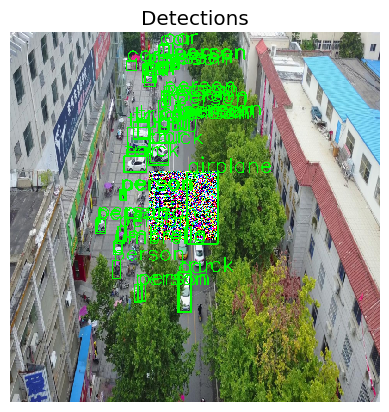

In [12]:
adv_detections = detector(px_adv)
for i in range(1): #to see all, use range(len(adv_detections)): 
    preds_orig = extract_predictions(adv_detections[i], 0.5)
    plot_image_with_boxes(img=px_adv[i].transpose(1,2,0).copy(),
                          boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

As expected, the resulting patch is now a square. 

## 7. Conclusion
The adversarial patch attack learns a patch that malicously affects object detection output. Via parameters, both the learning process but also position, size, and shape can be altered of the perturbation-special care has to be taken when it comes to the misclassification of specific objects, which can potentially be hidden behind the patch.

## 8. Next steps
- How-to 3 on defending object detection